# Update-Heavy but Enrolment-Light Regions

/Users/mrehanansari/Documents/UIDAI/phase zero/book1.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  consistency_metrics['load_volatility'].fillna(0, inplace=True)


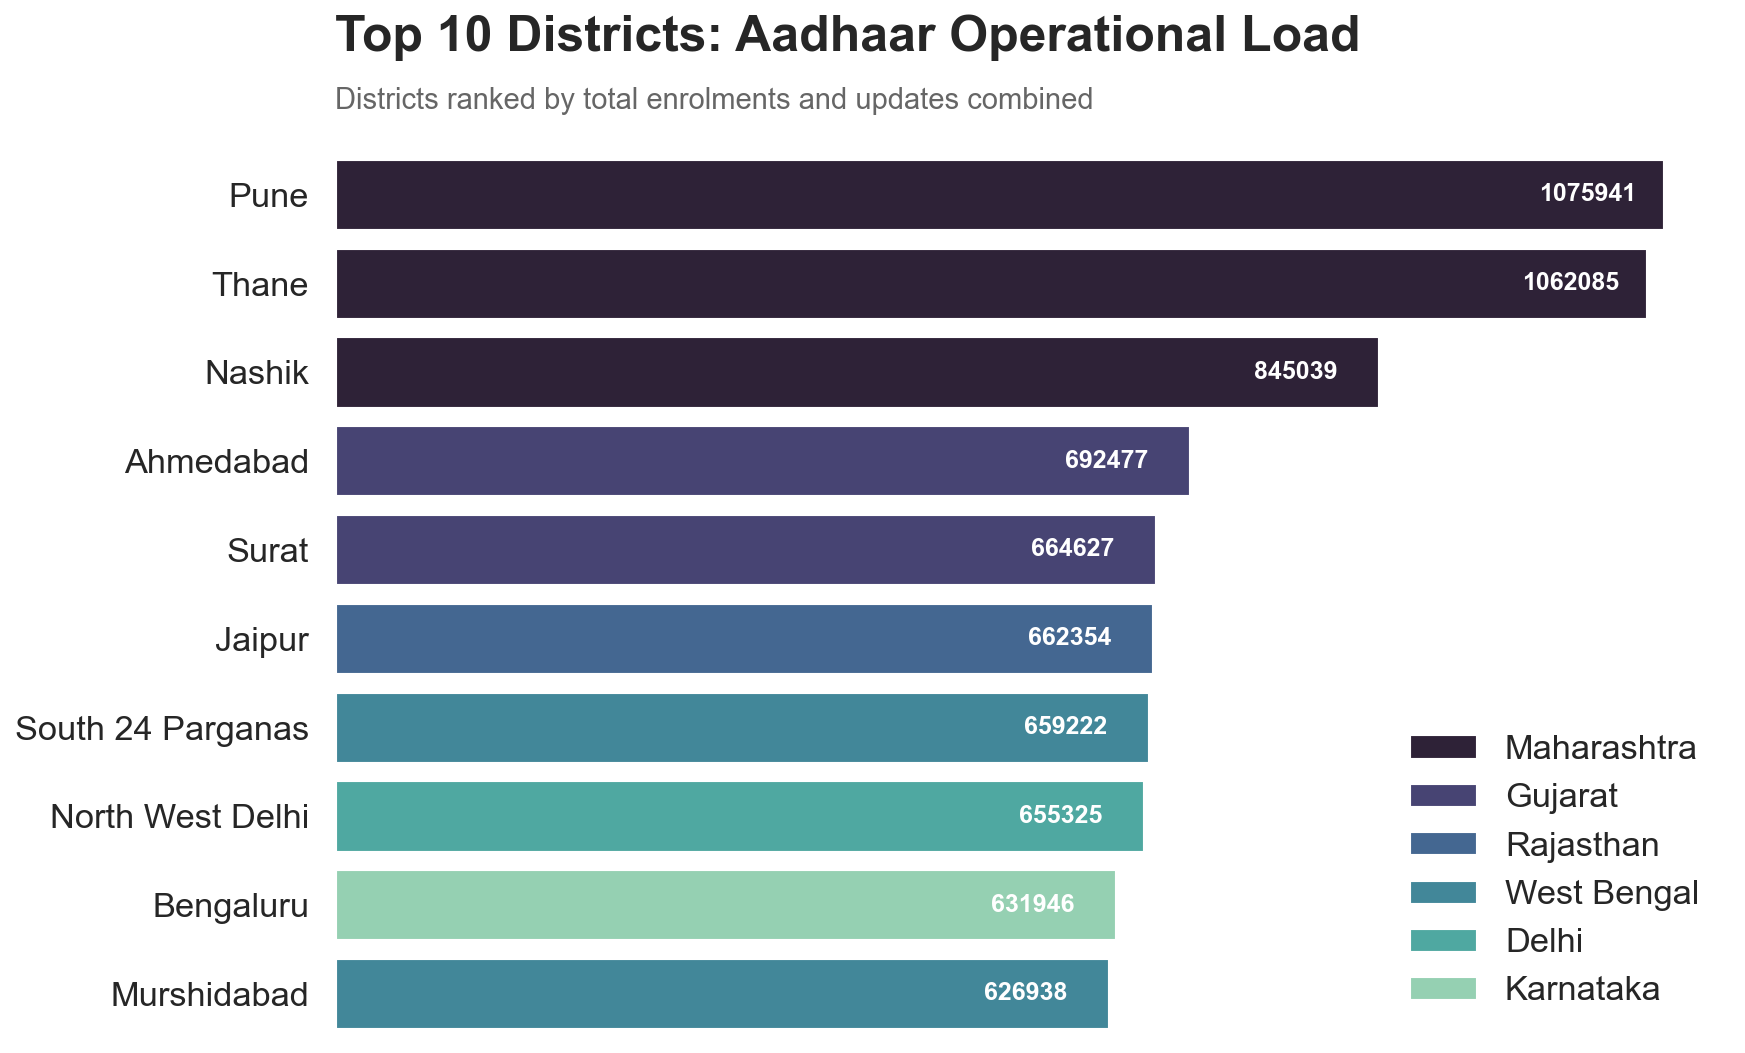

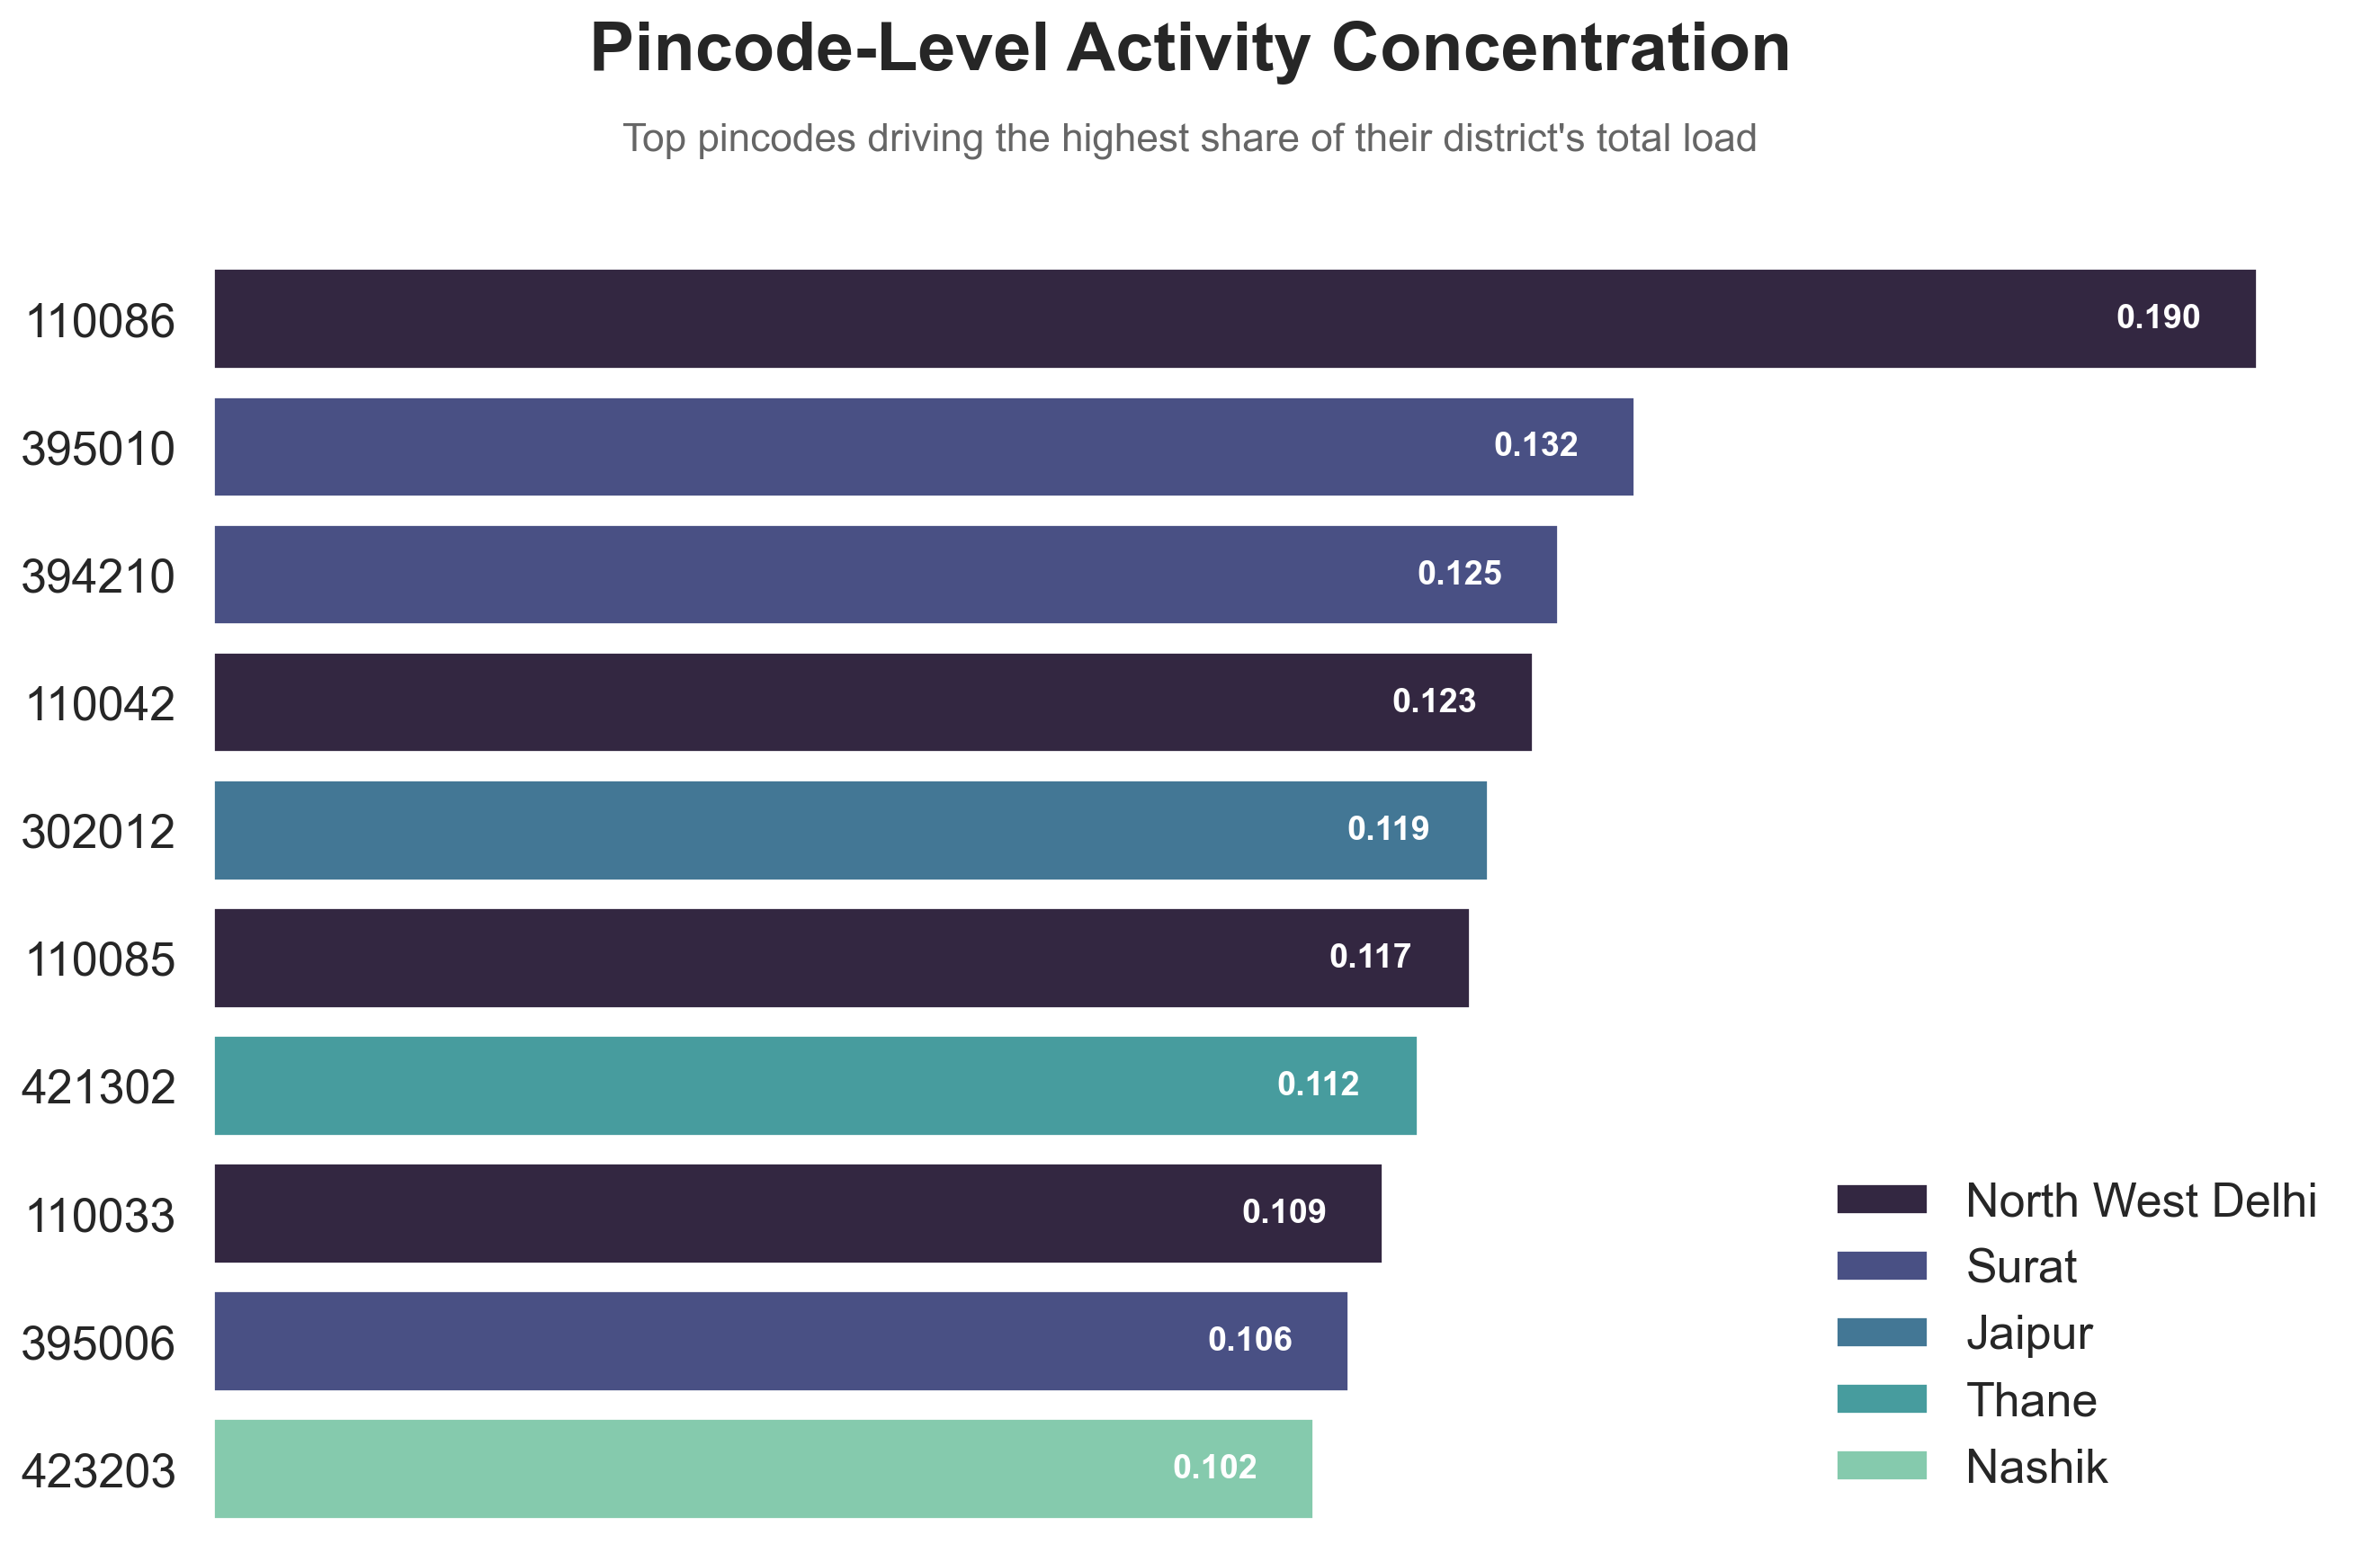

In [1]:
from book1 import pincode_df

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Re-aggregate to District Level & Filter Noise

In [2]:
# 1. Re-aggregate Pincode data back to District Level for Regional Analysis
region_df = pincode_df.groupby(['state', 'district'])[[
    'total_enrolments', 'demo_activity', 'bio_activity'
]].sum().reset_index()

# 2. Calculate Total Activity
region_df["total_activity"] = (
    region_df["total_enrolments"] +
    region_df["demo_activity"] +
    region_df["bio_activity"]
)

# --- GLOBAL DATA CLEANING START ---
# Fix State Names (Title Case, Strip, and Specific Replacements)
region_df['state'] = region_df['state'].str.title().str.strip()
region_df['state'] = region_df['state'].replace({
    'Westbengal': 'West Bengal',
    'Daman And Diu': 'Daman & Diu', 
    'Dadra And Nagar Haveli': 'Dadra & Nagar Haveli',
    'Andaman And Nicobar Islands': 'A & N Islands'
})

# Fix District Typos Globally (e.g. Medchal?malkajgiri)
region_df['district'] = region_df['district'].astype(str).str.replace('?', '-')
# --- GLOBAL DATA CLEANING END ---

# 3. Apply Minimum Volume Filter (Fixes "Small Number Noise")
# We only analyze districts with significant activity (> 1000 transactions)
VOLUME_THRESHOLD = 1000
region_df = region_df[region_df["total_activity"] > VOLUME_THRESHOLD].copy()

In [3]:
print(f"Districts after filtering: {len(region_df)}")
region_df.head()

Districts after filtering: 912


,state,district,total_enrolments,demo_activity,bio_activity,total_activity
1,Andaman & Nicobar Islands,Andamans,75,720.0,1970.0,2765.0
4,A & N Islands,Nicobar,75,787.0,1811.0,2673.0
5,A & N Islands,North And Middle Andaman,132,2008.0,6383.0,8523.0
6,A & N Islands,South Andaman,190,3320.0,9815.0,13325.0
7,Andhra Pradesh,Adilabad,1419,29183.0,51899.0,82501.0


## Compute Update Pressure Metrics

In [4]:
region_df["total_updates"] = (
    region_df["demo_activity"] +
    region_df["bio_activity"]
)

region_df["update_to_enrolment_ratio"] = (
    region_df["total_updates"] /
    region_df["total_enrolments"].replace(0, np.nan)
)

In [5]:
region_df[
    ["state", "district", "total_enrolments", "total_updates", "update_to_enrolment_ratio"]
].describe()

,total_enrolments,total_updates,update_to_enrolment_ratio
count,912.000000,9.120000e+02,912.000000
mean,5946.028509,1.304728e+05,27.097674
std,6675.810524,1.368460e+05,16.795161
min,9.000000,0.000000e+00,0.000000
25%,1155.500000,2.432675e+04,17.130297
50%,3770.500000,9.127250e+04,24.250350
75%,7987.000000,1.921572e+05,34.121728
max,43688.000000,1.044178e+06,198.777778


## Identify Update-Heavy

In [6]:
ratio_threshold = region_df["update_to_enrolment_ratio"].quantile(0.90)

update_heavy = region_df[
    region_df["update_to_enrolment_ratio"] >= ratio_threshold
].sort_values("update_to_enrolment_ratio", ascending=False)

In [7]:
print(f"Update-heavy districts found: {len(update_heavy)}")
update_heavy.head(10)

Update-heavy districts found: 92


,state,district,total_enrolments,demo_activity,bio_activity,total_activity,total_updates,update_to_enrolment_ratio
212,Daman & Diu,Daman,9,377.0,1412.0,1798.0,1789.0,198.777778
587,Manipur,Thoubal,1067,59243.0,56043.0,116353.0,115286.0,108.046860
580,Manipur,Imphal East,1132,55983.0,59255.0,116370.0,115238.0,101.800353
614,Mizoram,Serchhip,102,2455.0,7604.0,10161.0,10059.0,98.617647
581,Manipur,Imphal West,1236,59347.0,61307.0,121890.0,120654.0,97.616505
195,Chhattisgarh,Mohla-Manpur-Ambagarh Chouki,259,19811.0,4595.0,24665.0,24406.0,94.231660
214,Daman & Diu,Daman,58,1104.0,4033.0,5195.0,5137.0,88.568966
213,Daman & Diu,Diu,12,267.0,773.0,1052.0,1040.0,86.666667
167,Chhattisgarh,Balod,1678,59706.0,81180.0,142564.0,140886.0,83.960667
51,Andhra Pradesh,Warangal,1059,34682.0,51642.0,87383.0,86324.0,81.514636


## Visualization 1: Ratio-Based Stress

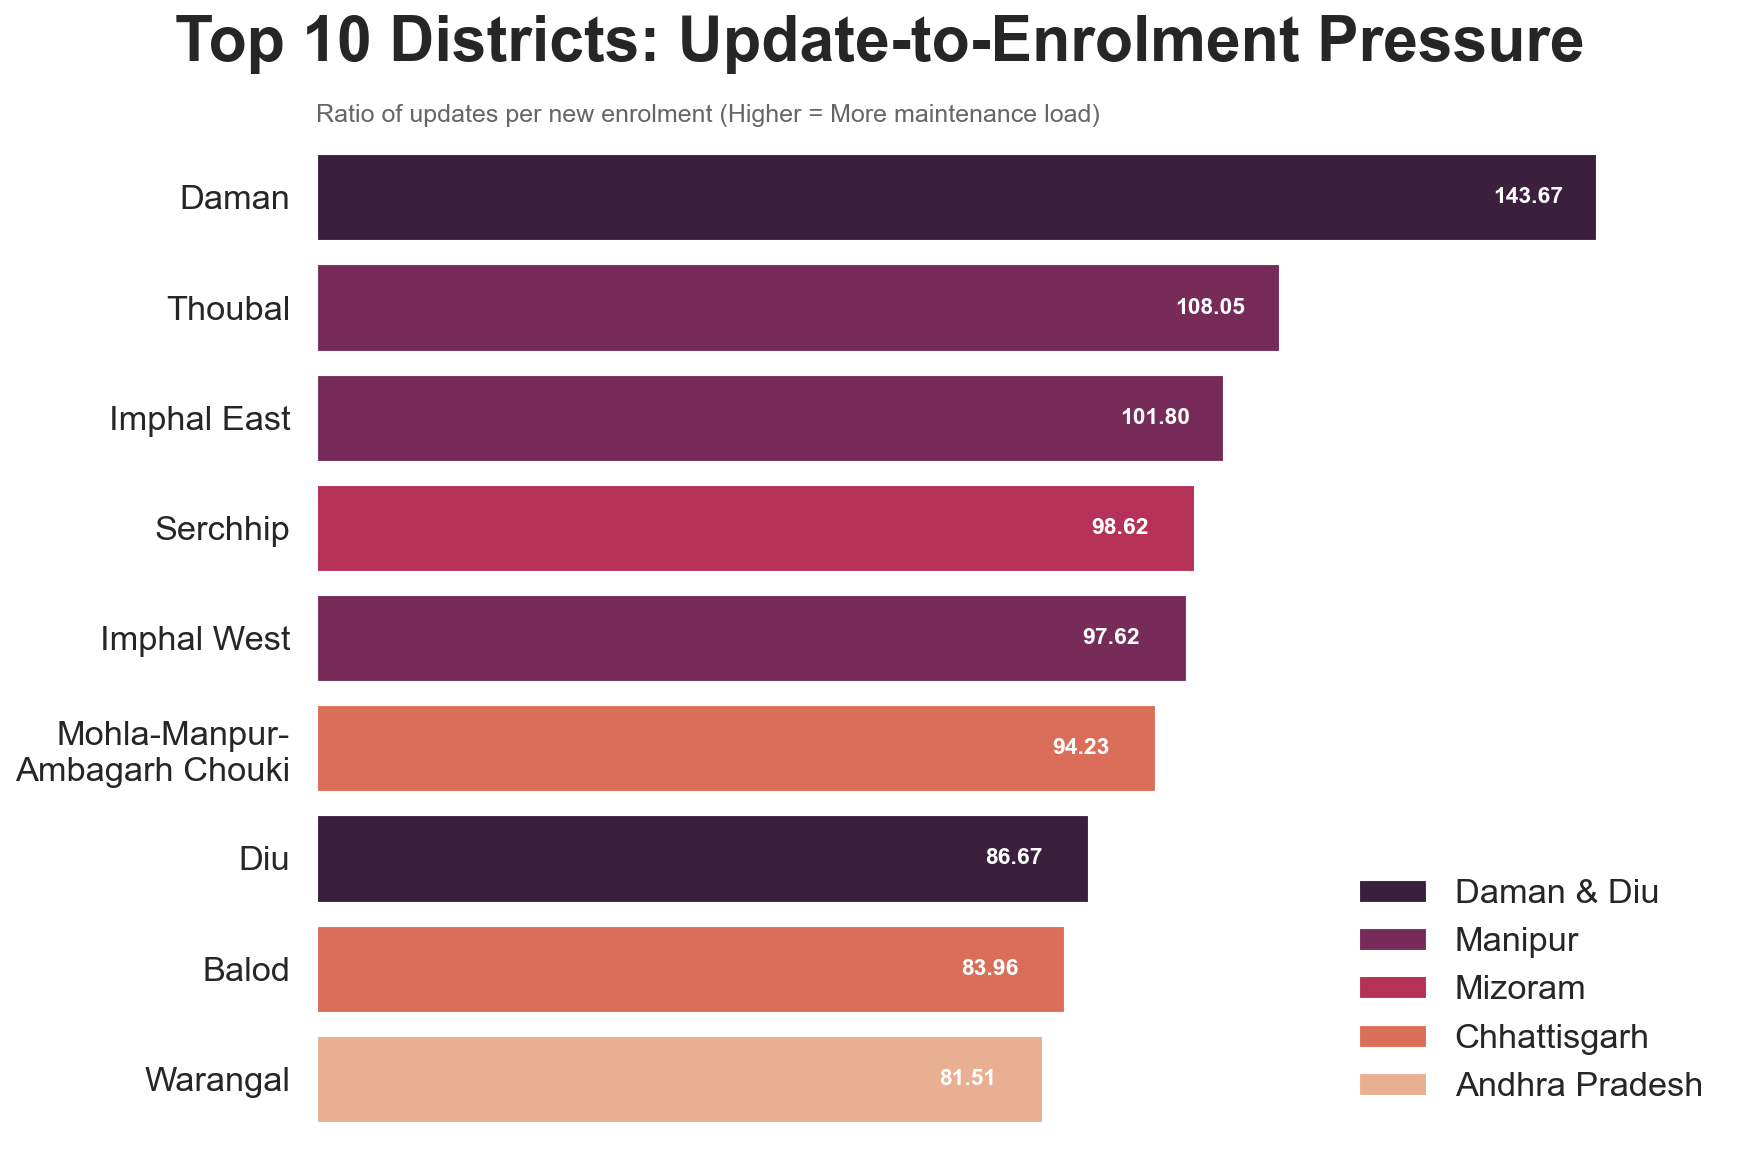

In [50]:
import textwrap

# Fix the Warning: Use .copy() to create a standalone table
top10_ratio = update_heavy.head(10).copy()

# --- FIX 1: HANDLE LONG NAMES (Word Wrap) ---
# Wraps names longer than 20 characters
top10_ratio['district'] = top10_ratio['district'].apply(
    lambda x: textwrap.fill(x, 15) if len(x) > 20 else x
)

# Create new figure for Graph 1
fig1, ax1 = plt.subplots(figsize=(12, 8), dpi=150)

sns.set_context("talk")
sns.set_style("white")

# Create the Plot
sns.barplot(
    data=top10_ratio,
    y="district",
    x="update_to_enrolment_ratio",
    hue="state",
    palette="rocket",
    dodge=False,
    errorbar=None, # --- FIX 2: REMOVE THE BLACK LINE ---
    ax=ax1
)

# --- FIX 3: CREATE SPACE FOR LEGEND ---
# Extend x-axis to make room on the right
max_val = top10_ratio['update_to_enrolment_ratio'].max()
ax1.set_xlim(0, max_val * 0.8)

# Title and Subtitle
ax1.set_title("Top 10 Districts: Update-to-Enrolment Pressure\n", 
              fontsize=30, weight='bold', loc='left', x= -0.1)
ax1.text(0, 1.02, "Ratio of updates per new enrolment (Higher = More maintenance load)", 
         fontsize=12, color='#666666', ha='left', transform=ax1.transAxes)

# Add Data Labels (White text inside bars)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', padding=-50, fontsize=11, color='white', weight='bold')

# Clean Axes
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xticks([])
sns.despine(left=True, bottom=True)

# Legend Fix: Move to lower right (now sits in the empty space)
sns.move_legend(
    ax1, "lower right",
    bbox_to_anchor=(1, 0),
    title="",
    frameon=False,
)

plt.tight_layout()
plt.show()

## Insight: Update-Heavy but Enrolment-Light Regions

### Several districts exhibit update activity that is disproportionately high relative to their enrolment volume.

This indicates that operational load in these regions is driven primarily by
identity maintenance rather than new enrolments.

Such districts require:
- Update-focused infrastructure planning
- Capacity allocation based on lifecycle load, not population size

This insight is derived entirely from relative, aggregated metrics and avoids
assumptions about individual behavior.

---
# Deeper Analysis: Split by Update Type (Bio vs Demo)
---

## Compute Split Update Ratios (Bio vs Demo)

In [10]:
# We calculate separate ratios to distinguish infrastructure needs
# Bio Ratio -> Need for Iris/Fingerprint Scanners
# Demo Ratio -> Need for Data Entry Terminals

region_df["bio_to_enrol_ratio"] = (
    region_df["bio_activity"] / region_df["total_enrolments"].replace(0, np.nan)
)

region_df["demo_to_enrol_ratio"] = (
    region_df["demo_activity"] / region_df["total_enrolments"].replace(0, np.nan)
)

# Total Maintenance Ratio (for sorting)
region_df["total_maintenance_ratio"] = region_df["bio_to_enrol_ratio"] + region_df["demo_to_enrol_ratio"]

In [11]:
region_df[
    ["state", "district", "total_enrolments", "bio_to_enrol_ratio", "demo_to_enrol_ratio", "total_maintenance_ratio"]
].describe()

,total_enrolments,bio_to_enrol_ratio,demo_to_enrol_ratio,total_maintenance_ratio
count,912.000000,912.000000,912.000000,912.000000
mean,5946.028509,16.203373,10.894302,27.097674
std,6675.810524,11.902362,7.364303,16.795161
min,9.000000,0.000000,0.000000,0.000000
25%,1155.500000,8.419313,6.685612,17.130297
50%,3770.500000,13.560793,9.629395,24.250350
75%,7987.000000,21.817794,13.138523,34.121728
max,43688.000000,156.888889,76.490347,198.777778


## Identify Maintenance-Heavy Districts

In [12]:
maintenance_threshold = region_df["total_maintenance_ratio"].quantile(0.90)

maintenance_heavy = region_df[
    region_df["total_maintenance_ratio"] >= maintenance_threshold
].sort_values("total_maintenance_ratio", ascending=False)

In [13]:
print(f"Maintenance-heavy districts found: {len(maintenance_heavy)}")
maintenance_heavy.head(10)

Maintenance-heavy districts found: 92


,state,district,total_enrolments,demo_activity,bio_activity,total_activity,total_updates,update_to_enrolment_ratio,bio_to_enrol_ratio,demo_to_enrol_ratio,total_maintenance_ratio
212,Daman & Diu,Daman,9,377.0,1412.0,1798.0,1789.0,198.777778,156.888889,41.888889,198.777778
587,Manipur,Thoubal,1067,59243.0,56043.0,116353.0,115286.0,108.046860,52.523899,55.522962,108.046860
580,Manipur,Imphal East,1132,55983.0,59255.0,116370.0,115238.0,101.800353,52.345406,49.454947,101.800353
614,Mizoram,Serchhip,102,2455.0,7604.0,10161.0,10059.0,98.617647,74.549020,24.068627,98.617647
581,Manipur,Imphal West,1236,59347.0,61307.0,121890.0,120654.0,97.616505,49.601133,48.015372,97.616505
195,Chhattisgarh,Mohla-Manpur-Ambagarh Chouki,259,19811.0,4595.0,24665.0,24406.0,94.231660,17.741313,76.490347,94.231660
214,Daman & Diu,Daman,58,1104.0,4033.0,5195.0,5137.0,88.568966,69.534483,19.034483,88.568966
213,Daman & Diu,Diu,12,267.0,773.0,1052.0,1040.0,86.666667,64.416667,22.250000,86.666667
167,Chhattisgarh,Balod,1678,59706.0,81180.0,142564.0,140886.0,83.960667,48.379023,35.581645,83.960667
51,Andhra Pradesh,Warangal,1059,34682.0,51642.0,87383.0,86324.0,81.514636,48.764873,32.749764,81.514636


## Visualization 2: Maintenance-Heavy Districts by Dominant Need

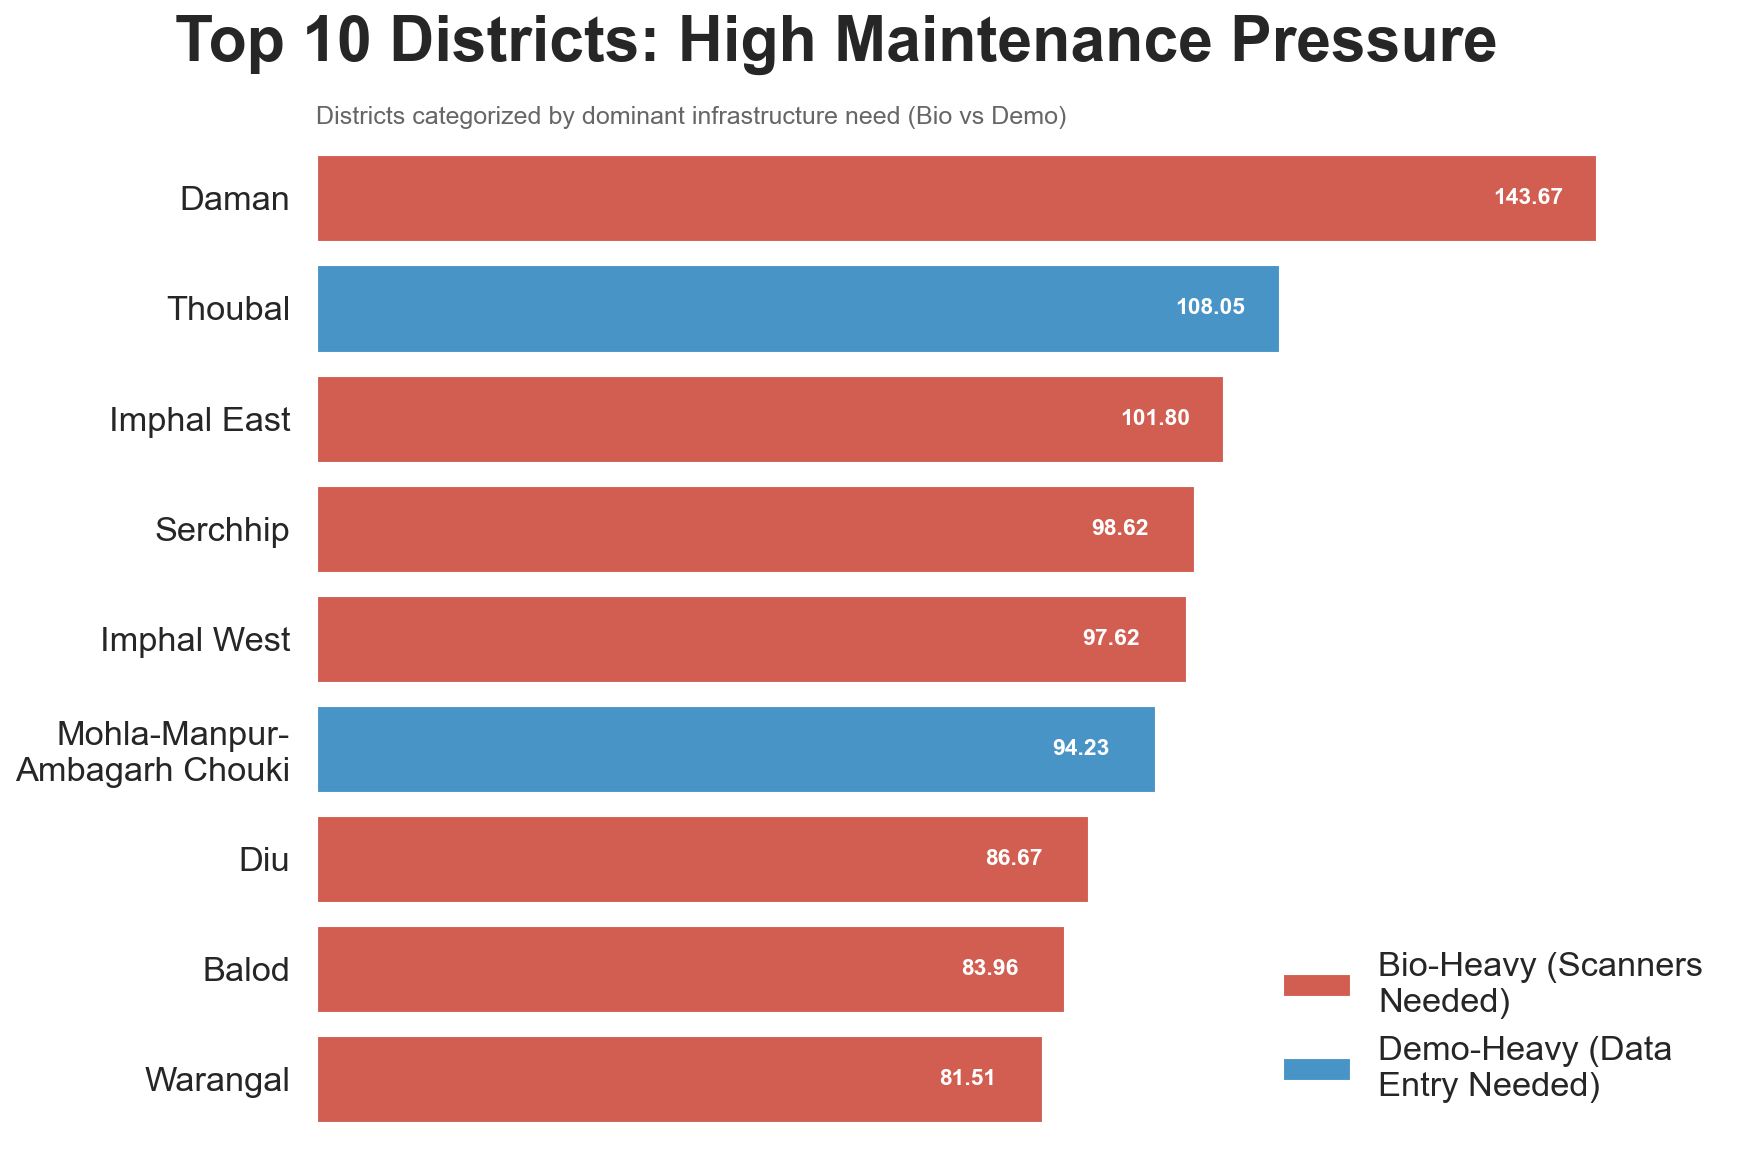

In [52]:
import textwrap

# Fix the Warning: Use .copy() to create a standalone table
top10_maintenance = maintenance_heavy.head(10).copy()

# --- FIX 1: HANDLE LONG NAMES (DISTRICTS) ---
# This wraps any name longer than 20 chars into multiple lines
top10_maintenance['district'] = top10_maintenance['district'].apply(
    lambda x: textwrap.fill(x, 15) if len(x) > 20 else x
)

# Determine Dominant Need for coloring
def get_dominant_need(row):
    if row['bio_to_enrol_ratio'] > row['demo_to_enrol_ratio']:
        return 'Bio-Heavy (Scanners Needed)'
    else:
        return 'Demo-Heavy (Data Entry Needed)'

top10_maintenance['dominant_need'] = top10_maintenance.apply(get_dominant_need, axis=1)

# Create new figure for Graph 2
fig2, ax2 = plt.subplots(figsize=(12, 8), dpi=150)

sns.set_context("talk")
sns.set_style("white")

# Create the Plot
sns.barplot(
    data=top10_maintenance,
    y="district",
    x="total_maintenance_ratio",
    hue="dominant_need",
    palette={"Bio-Heavy (Scanners Needed)": "#e74c3c", "Demo-Heavy (Data Entry Needed)": "#3498db"},
    dodge=False,
    errorbar=None,
    ax=ax2
)

# --- FIX 2: CREATE SPACE FOR LEGEND ---
# Get the maximum value and add padding to the right so the legend fits
max_val = top10_maintenance['total_maintenance_ratio'].max()
ax2.set_xlim(0, max_val * 0.8)

# Title and Subtitle
ax2.set_title("Top 10 Districts: High Maintenance Pressure\n", 
              fontsize=30, weight='bold', loc='left', x= -0.1)
ax2.text(0, 1.02, "Districts categorized by dominant infrastructure need (Bio vs Demo)", 
         fontsize=12, color='#666666', ha='left', transform=ax2.transAxes)

# Add Data Labels
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', padding=-50, fontsize=11, color='white', weight='bold')

# Clean Axes
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_xticks([])
sns.despine(left=True, bottom=True)

# Legend Fix: Move to lower right
sns.move_legend(
    ax2, "lower right",
    bbox_to_anchor=(1, 0),
    title="",
    frameon=False,
)

# --- FIX 3: WRAP LEGEND TEXT ---
# Access the legend created above and wrap the text to 20 characters
for text in ax2.get_legend().get_texts():
    text.set_text(textwrap.fill(text.get_text(), 20))

plt.tight_layout()
plt.show()

## Insight: Maintenance-Heavy Districts by Dominant Need

### By splitting the update ratios, we can now distinguish the specific infrastructure need for each district.

The analysis reveals two distinct categories:
- **Biometric Heavy (Red):** Regions where residents are primarily updating biometrics (fingerprints, iris). These require more Iris/Fingerprint Scanners.
- **Demographic Heavy (Blue):** Regions with high address/name changes (likely due to migration). These require more Data Entry Terminals.

This distinction enables UIDAI to:
- Allocate equipment budgets more precisely
- Deploy the RIGHT type of infrastructure to each district
- Avoid wasteful spending on wrong equipment

*Note: Volume filter (>1000) ensures these are operationally significant districts, not statistical noise.*

---

## Contrast Check

In [16]:
# Comparing with high enrolment districts to see the difference
region_df.sort_values(
    "total_enrolments", ascending=False
)[
    ["state", "district", "total_enrolments", "update_to_enrolment_ratio", "total_maintenance_ratio"]
].head(10)

,state,district,total_enrolments,update_to_enrolment_ratio,total_maintenance_ratio
572,Maharashtra,Thane,43688,23.310680,23.310680
160,Bihar,Sitamarhi,42232,8.331218,8.331218
910,Uttar Pradesh,Bahraich,39338,7.900122,7.900122
1044,West Bengal,Murshidabad,35911,16.458105,16.458105
1057,West Bengal,South 24 Parganas,33540,18.654800,18.654800
563,Maharashtra,Pune,31763,32.874036,32.874036
771,Rajasthan,Jaipur,31146,20.266102,20.266102
397,Karnataka,Bengaluru,30980,19.398515,19.398515
983,Uttar Pradesh,Sitapur,30854,14.054353,14.054353
164,Bihar,West Champaran,30438,13.148137,13.148137


## Combined Insight: Update-Heavy but Enrolment-Light Regions

### Several districts exhibit update activity that is disproportionately high relative to their enrolment volume.

**Graph 1 (Update-to-Enrolment Pressure)** shows us WHICH districts have high update pressure overall.

**Graph 2 (Maintenance by Dominant Need)** tells us WHAT TYPE of updates are driving that pressure.

Together, these insights enable:
- Update-focused infrastructure planning
- Capacity allocation based on lifecycle load, not population size
- Precise equipment deployment (Scanners vs Data Entry)

This insight is derived entirely from relative, aggregated metrics and avoids
assumptions about individual behavior.

*Note: We applied a volume filter (>1000) to ensure these are significant operational centers, not statistical noise.*